<a href="https://colab.research.google.com/github/annaei/replication-data-for-eilertsen-murphy-TSE/blob/main/tse_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook generates charts for the paper The Usability of Refactoring Tools, by Anna Eilertsen and Gail Murphy, submitted to TSE in 2021. 

# Boilerplate

### Install/upgrade dependencies 

In [12]:
!pip install lmfit

### Import dependencies

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import copy
import numpy as np
import numpy.ma as ma

### Declare Utility Functions

In [14]:
def acc(numArr):
    retVal = 0
    for n in numArr:
        retVal += n
    return retVal

def cleanEmpty(d):
    if '' in d:
        del d['']

def getDictionaryFromColumn(column, valuesToRemove=[], replaceValue=""):
    # assert isinstance(valuesToRemove, list)
    d = {}
    for v in column:
        for remove in valuesToRemove:
            v = v.replace(remove, replaceValue)
        if isinstance(v, str) and "," in v:
            v = v.split(",")
        if not isinstance(v, list):
            v = [v]
        for s in v:
            if s in d:
                d[s] += 1
            else:
                d[s] = 1
    return d

### Radar diagram boilerplate code

In [15]:
from pylab import *
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.transforms import Affine2D
import matplotlib.projections.polar
import matplotlib.projections
from matplotlib.patches import RegularPolygon

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    matplotlib.projections.register_projection(RadarAxes)
    return theta

# Import data and set up datastructures

In [16]:
__data = pd.read_csv("data/csv/Responses.csv", nrows=50, na_filter=False)

__columns = []
for d in __data:
    __columns.append(d)
COLUMNS = __columns

values = __data[0:46] #hardcoded values [0:x] to cut out any calculations such as sums, averages, etc, on rows >x in the sheet
assert len(values) == 46, len(values)
orderedValuesToRemove = [" \([^\)]*\)", ", please specify", "-99"]
orderedValuesToReplace = ["", "", "NA"]
participant_data = pd.DataFrame.from_records(values, columns=COLUMNS).replace(to_replace=orderedValuesToRemove, value=orderedValuesToReplace, regex=True)
assert len(participant_data) == 46, len(participant_data)

__data = pd.read_csv("data/csv/Mapping.csv")
__columns = []
for d in __data:
    __columns.append(d)
__allMaps = pd.DataFrame.from_records(__data, columns=__columns)

assert len(participant_data[COLUMNS[0]]) == 46, str(len(participant_data[COLUMNS[0]]))
"""List of exact IDE strings"""
IDEs = list(getDictionaryFromColumn(participant_data['IDEs used']).keys())
"""List of exact Tool strings are they are used in Tool Questions"""
TOOLS = list(getDictionaryFromColumn(participant_data['USEFUL-TOOLS']).keys())
print(getDictionaryFromColumn(participant_data['USEFUL-TOOLS']))
"""List of factor short keywords used to match full strings"""
FACTORS = ['predictable', 'effective', 'satisfying', 'trust', 'time']
"""List of possible values for education"""
EDUCATION = list(getDictionaryFromColumn(participant_data['Education']).keys())
"""Color codes"""
mycmap = "Blues"

# In the following code, scenarios are referred to as A="Move", B="Inline", C="CS"
# The following dictionaries map full-text answers to strategies 
APPROACH_INLINE = dict(zip(list(__allMaps['Inline-Key']), list(__allMaps['Inline-Strategy'])))
cleanEmpty(APPROACH_INLINE)
#print("Inline Task mapping for answers:")
#print(APPROACH_INLINE)
APPROACH_CS = dict(zip(list(__allMaps['CS-Key']), list(__allMaps['CS-Strategy'])))
cleanEmpty(APPROACH_CS)
#print("Change Signature Task mapping for answers:")
#print(APPROACH_CS)
APPROACH_MOVE = dict(zip(list(__allMaps['Move-Key']), list(__allMaps['Move-Strategy'])))
cleanEmpty(APPROACH_MOVE)
#print("Move Task mapping for answers:")
#print(APPROACH_MOVE)

{'Simple Refactoring tools': 41, 'Complex Refactoring tools': 31, 'Version Control Systems "diffs"': 42, 'Compiler output': 36, 'Textual search': 37, 'Structural navigation': 42, 'Copy/cut and paste code': 37, 'Test suites': 34, 'Debugging tools': 37}


### Declare utility functions for accessing data

In [17]:
# keys that indicate that a string contains a refactoring name from they survey
REFACTORING_TOOLS =["Rename", "Safe Delete", "Extract",  "Move", "Change Signature", "Inline",  "Remove Parameter"]

FACTOR_COLUMN_KEYS = list(filter(lambda x : "Necessary" in x, COLUMNS))
keymap = {"move":"move", "inline":"inline", "signature":"cs"}
SCENARIO_KEY_DICT = {"move" : {}, "inline" :{}, "cs":{}}
# extract scenario column keys
for s in keymap.keys() :
  tmpList = list(filter(lambda x : s.capitalize() +"-" in x and "Task" not in x, COLUMNS))
  for k in tmpList:
    ls = k.lower().split("-")
    SCENARIO_KEY_DICT[keymap[s]][ls[len(ls)-1]] = k

def getShortFactor(factor):
    for word in FACTORS:
        if word in factor:
            return word
    return None

def getLabelFactor(factor):
  factor = getShortFactor(factor)
  assert factor in FACTORS, "called getLabelFactor on something that is not a factor: " + factor
  factor = factor.replace("time", "Efficient")
  factor = factor.replace("predictable", "Predictable")
  factor = factor.replace("trust", "Trustworthy")
  factor = factor.replace("satisfying", "Satisfying")
  factor = factor.replace("effective", "Effective")
  return factor

def getLabelTool(tool):
  tool = tool.lower()
  if "simple" in tool : return "simple-refactoring"
  if "complex" in tool : return "complex-refactoring"
  if "refactoring" in tool : return "refactoring-tool"
  if "debug" in tool : return "debugging-tool"
  if "suite" in tool : return "test-suite"
  if "compiler" in tool : return "compiler-output"
  if "copy" in tool : return "copy/cut/paste"
  if "text" in tool : return "text-search"
  if "struct" in tool : return "structural-navigation"
  if "diff" in tool : return "VCS-diff"
  assert False, "called getLabelTool on unknown tool: " + tool

def getLabelScenario(scenario): 
  if "move" in scenario : return "Scenario A"
  if "inline" in scenario : return "Scenario B"
  if "cs" in scenario or "change" in scenario: return "Scenario C"
  assert False, "called getLabelScenario on unknown scenario: " + scenario

def getLabelStrategy(strategy): 
  strategy = strategy.lower()
  if "none" in strategy : return "Other"
  assert strategy in "structurelocalexecute", "called getStrategyLabel on unknown strategy: " + strategy
  return strategy.capitalize()

def getFactorIndex(factor):
    for word in FACTORS:
        if word in factor:
            return FACTORS.index(word)
    if "Other" in factor:
        return 5

def replaceLabelsTools(xs): 
  return __replaceLabel(xs, getLabelTool)

def replaceLabelsScenarios(xs): 
  return __replaceLabel(xs, getLabelScenario)

def replaceLabelsStrategies(xs): 
  return __replaceLabel(xs, getLabelStrategy)

def replaceLabelsFactors(xs): 
  return __replaceLabel(xs, getLabelFactor)

def __replaceLabel(xs, func):
  return list(map(lambda x : func(x), xs))

# assumptions: toolString is a string containing only tools that were provided to participants as options in this study
def isScenarioTool(scenario, toolString):
    if scenario == "move":
        return "Move" in toolString
    if scenario == "inline":
        return "Inline" in toolString
    if scenario == "cs":
        return "Change Signature" in toolString  # or "Parameter" in toolString


print(FACTORS)
print(SCENARIO_KEY_DICT)

['predictable', 'effective', 'satisfying', 'trust', 'time']
{'move': {'strategy': 'Move-Strategy', 'tool': 'Move-Tool', 'why': 'Move-Why', 'factor': 'Move-Factor'}, 'inline': {'strategy': 'Inline-Strategy', 'tool': 'Inline-Tool', 'why': 'Inline-Why', 'factor': 'Inline-Factor'}, 'cs': {'strategy': 'Change-Signature-Strategy', 'tool': 'Change-Signature-Tool', 'why': 'Change-Signature-Why', 'factor': 'Change-Signature-Factor'}}


# Tool Questions
Presents an overview of the number of times each factor is selected per tool

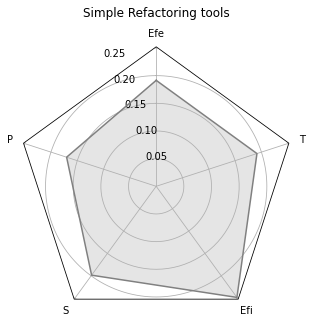

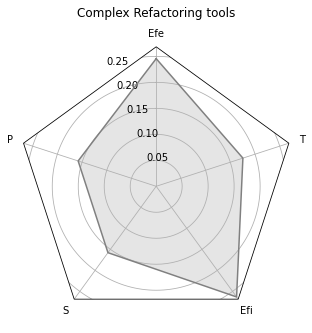

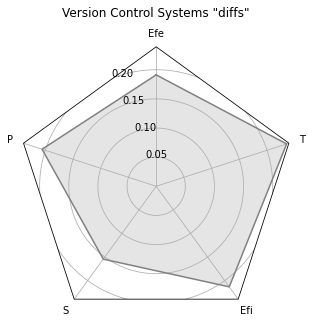

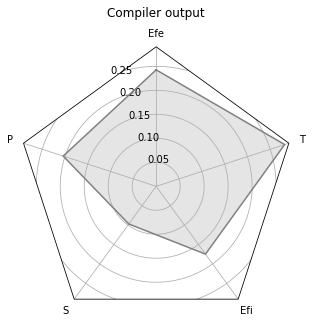

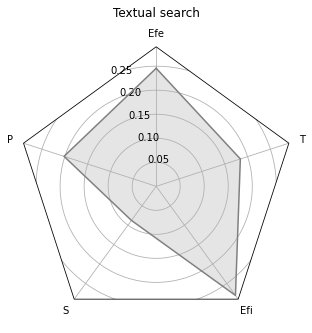

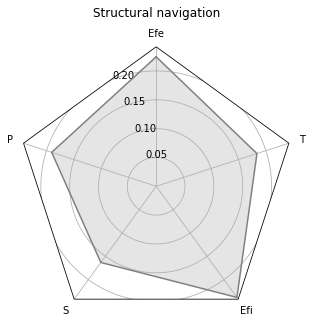

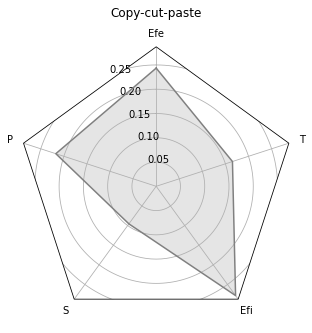

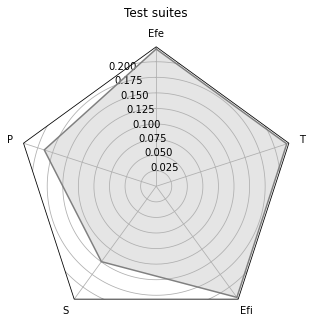

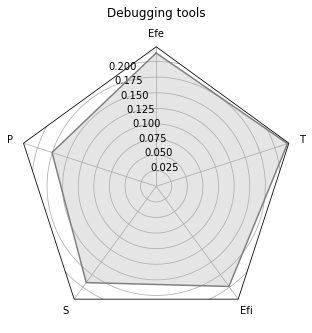

In [18]:
# Produces the simple count of factors per tool
def getDictToolFactor():
  myFactors = set([])
  d = {}
  for tool in TOOLS:
    d[tool] = {} # factor set for this tool 
    values = participant_data["Necessary-"+tool]
    tmp = getDictionaryFromColumn(values)
    if "NA" in tmp : 
      del tmp["NA"]
    if "" in tmp:
      del tmp[""]
    for factor in tmp.keys(): 
      myFactors.update([getShortFactor(factor)])
    for factor in tmp : 
      if factor not in d[tool] : 
        d[tool][getShortFactor(factor)] = 0
      d[tool][getShortFactor(factor)] += tmp.get(factor, 0)
  return myFactors, d 

myFactors, dataDict = getDictToolFactor()
myFactors = sorted(myFactors)

# Build datastructure for diagrams
data = [list(sorted(myFactors))]
for tool in dataDict.keys(): 
  row = []
  for factor in data[0]:
    row.append(dataDict[tool].get(factor, 0))
  data.append((tool, row))

# Figure 
simpleRefactoring = () 
complexRefactoring = () 

N = 5
theta = radar_factory(N, frame='polygon')
spoke_labels = replaceLabelsFactors(data.pop(0))

for i in range(0, len(spoke_labels)):
  spoke_labels[i] = spoke_labels[i].replace("Predictable", "P").replace("Effective", "Efe").replace("Efficient", "Efi").replace("Satisfying", "S").replace("Trustworthy", "T")

# Plot the factors on separate axes
for (title, case_data) in data:
  #retain references to refactoring outlines for later
  if "imple" in title : simpleRefactoring = (title, case_data)
  if "omplex" in title : complexRefactoring = (title, case_data)

  fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
  fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
  sum = acc(case_data)
  for i in range(len(case_data)): 
    case_data[i] = case_data[i]/sum
  ax.plot(theta, case_data, color="gray", label=title)
  ax.fill(theta, case_data, facecolor="gray", alpha=0.2)
  ax.set_varlabels(spoke_labels)
  if "Copy" in title : title = "Copy-cut-paste"
  ax.set_title(title, size='large', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
  plt.savefig(title+"-Radar-diagram.pdf", bbox_inches='tight')

plt.show()

# Scenario Questions

### Scenario Summary

In [19]:
SCENARIO_RESPONSES = {} 
for scenario in SCENARIO_KEY_DICT : 
  SCENARIO_RESPONSES[scenario] = {} 
  values = participant_data[SCENARIO_KEY_DICT[scenario]["strategy"]]
  tmp = getDictionaryFromColumn(values)
  if tmp[""] : del tmp[""]
  print(scenario + " " + str(acc(tmp.values())))
  print(tmp)
  SCENARIO_RESPONSES[scenario] = tmp
print(SCENARIO_RESPONSES)

move 23
{'Structure': 7, 'Local': 13, 'None of the above': 1, 'Execute': 2}
inline 26
{'Structure': 13, 'Execute': 4, 'Local': 7, 'None of the above': 2}
cs 20
{'Execute': 6, 'None of the above': 4, 'Structure': 8, 'Local': 2}
{'move': {'Structure': 7, 'Local': 13, 'None of the above': 1, 'Execute': 2}, 'inline': {'Structure': 13, 'Execute': 4, 'Local': 7, 'None of the above': 2}, 'cs': {'Execute': 6, 'None of the above': 4, 'Structure': 8, 'Local': 2}}


## Factors that impacted decision not to select tool on scenarios

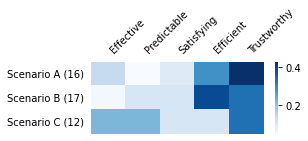

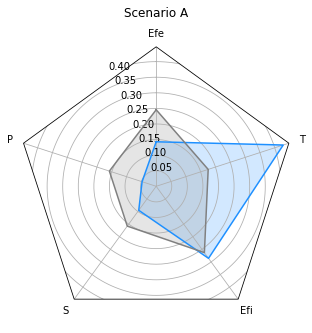

In [20]:
# Gather initial data 
d = {}
ps = participant_data["ResponseId"]

# initialize 
factorRefTool=[0]*5 
responses = 6
for i in range(0, len(ps)):
  p=ps[i]
  d[p]={}
  d[p]["move"]=[False]*responses
  d[p]["cs"]=[False]*responses
  d[p]["inline"]=[False]*responses
  
scenarioFactors = {"move":[0]*6, "inline":[0]*6, "cs":[0]*6}
scenarioSolved = {"move":0, "inline":0, "cs":0}
scenarioAutomated = {"move":0, "inline":0, "cs":0}
scenarioFactorResponse = {"move":0, "inline":0, "cs":0}

# Gather data and slice  
for scenario in SCENARIO_KEY_DICT.keys(): 
  strategy = participant_data[SCENARIO_KEY_DICT[scenario]["strategy"]]
  factors = participant_data[SCENARIO_KEY_DICT[scenario]["factor"]]
  tools = participant_data[SCENARIO_KEY_DICT[scenario]["tool"]]
  #print(tools)
  for i in range(0, len(ps)) : 
    if len(strategy[i])>0:
      scenarioSolved[scenario]+=1 
    if len(factors[i])>0:
      scenarioFactorResponse[scenario]+=1
    if isScenarioTool(scenario, tools[i]): 
      #print("participant used appropriate automation on the task: " + tools[i])
      d[ps[i]][scenario]=["automation"]#[tools[i]]#debug
      scenarioAutomated[scenario]+=1
      #toBeRemoved.append((ps[i], scenario)) 
      continue
    if len(tools[i]) == 0 : 
      #print("participant did not give a response")
      if len(strategy[i])==0:
        d[ps[i]][scenario]=["did not solve scenario"] #debug
      else: 
        d[ps[i]][scenario]=[strategy[i]] #debug
      #toBeRemoved.append((ps[i], scenario)) 
      continue
    #print("participant did not use appropriate automation on the task: " + tools[i])
    row = factors[i].split(",")
    if len(row)=="0":toBeRemoved.append((ps[i], scenario))
    for f in row : 
      if getFactorIndex(f) == None : continue
      #print("Comparing: " + factors[i] + " and " + factorSimple[i] + " and complex: " + factorComplex[i])
      d[ps[i]][scenario][getFactorIndex(f)]=True
      scenarioFactors[scenario][getFactorIndex(f)]+=1

# Create data-structures for heatmap  
xtic = sorted(FACTORS)
ytic = ["move", "inline", "cs"]
scenarioFactors["general"]=factorRefTool
data = [] 

# Generate data for heatmap and scale
for y in ytic: 
  row = scenarioFactors[y][0:5]
  rowSum = acc(row)
  row = list(map(lambda x : x/rowSum, row))
  data.append(row)

# Add count to scenario labels
yticklabelsAndCount=replaceLabelsScenarios(ytic)
for i in range(0, len(yticklabelsAndCount)) : 
  yticklabelsAndCount[i] = yticklabelsAndCount[i].replace("A", "A (" + str(scenarioFactorResponse["move"]) + ")")
  yticklabelsAndCount[i] = yticklabelsAndCount[i].replace("B", "B (" + str(scenarioFactorResponse["inline"]) + ")")
  yticklabelsAndCount[i] = yticklabelsAndCount[i].replace("C", "C (" + str(scenarioFactorResponse["cs"]) + ")")

# Create heatmap figure 
fig = plt.figure(figsize=(3,1))
plt.subplots_adjust(left=1, bottom=1, right=2, top=2, wspace=0, hspace=0)
ax = sns.heatmap(data, annot = False, xticklabels=replaceLabelsFactors(xtic), yticklabels=yticklabelsAndCount, cmap=mycmap)
ax.tick_params(bottom=False, left = False, top=False, labeltop=True, labelbottom=False)
plt.xticks(rotation=45, ha="left") 
plt.yticks(rotation=0) 
plt.savefig("factors-on-changes.pdf", bbox_inches='tight')

# Create radar figure 
N = 5
theta = radar_factory(N, frame='polygon')
spoke_labels = xtic
for i in range(0, len(spoke_labels)):
  spoke_labels[i] = spoke_labels[i].replace("predictable", "P").replace("effective", "Efe").replace("time", "Efi").replace("satisfying", "S").replace("trust", "T")

# Plot the factors on separate axes
for title in scenarioFactors.keys():
  if "general" in title: continue 
  if not "move" in title: continue #paper only shows for Scenario A 
  case_data = scenarioFactors.get(title)[0:5]
  fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
  fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
  sum = acc(case_data)
  for i in range(len(case_data)): 
    case_data[i] = case_data[i]/sum
  ax.plot(theta, case_data, color="dodgerblue", label=title)
  ax.fill(theta, case_data, facecolor="dodgerblue", alpha=0.2)
  ax.plot(theta, complexRefactoring[1], color="gray", label="CompRef")
  ax.fill(theta, complexRefactoring[1], facecolor="gray", alpha=0.2)
  ax.set_varlabels(spoke_labels)
  ax.set_title("Scenario A", size='large', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
  plt.savefig(title+"-Radar-diagram.pdf", bbox_inches='tight')

plt.show()